In [4]:
# import 
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import pickle

### Load Models

In [29]:
# infer_RHNH = keras.models.load_model('../../Weights/helmet_no_helmet_512')
infer_RHNH = keras.models.load_model('../Weights/yolov4/helmet_no_helmet_ROI')
infer_rider_motor = keras.models.load_model('../Weights/yolov4/rider_motor_512')
trapez_model = pickle.load(open('../Weights/trapezium_regressor/Trapezium_Prediction_Weights.pickle', 'rb'))

c:\Users\basur\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:299: UserWarning: Trying to unpickle estimator MLPRegressor from version 0.22.2.post1 when using version 1.2.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


### Load Images from Validation Set

In [30]:
import os

frames = []
frames2 = []

# Storing all the Validation Images 
# Images are all files with .jpg in data/validation_data_234Images

for file in os.listdir('../data/testing_data_310Images/final_test_set/'):
    if file.endswith('.jpg') or file.endswith('.jpeg'):
        # read the image and storing 2 copies of it for annotation purposes 
        img1 = cv2.imread(os.path.join('../data/testing_data_310Images/final_test_set/', file))
        img2 = img1.copy()
        img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
        img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
        frames.append(img1)
        frames2.append(img2)

No of Images 4
			Random Images from Test Data


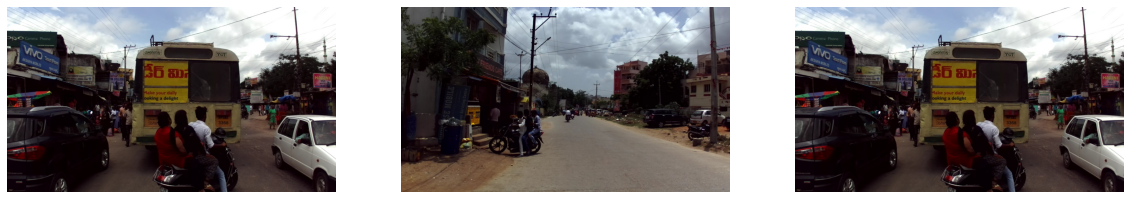

In [31]:
# limit to first 10 images
frames = frames[:4]
frames2 = frames2[:4]

print("No of Images", len(frames))
# Print 3 random images in a single row
fig, ax = plt.subplots(1, 3, figsize=(20, 20))
print('\t\t\tRandom Images from Test Data')
random_indices = np.random.randint(0, len(frames), 3)
for i, idx in enumerate(random_indices):
    ax[i].imshow(frames[idx])
    ax[i].axis('off')
plt.show()

### Prepare Image input for Model

In [32]:
input_size = 512
all_batch_data = []
for i, frame in enumerate(frames):
    frame_size = frame.shape[:2]
    image_data = cv2.resize(frame, (input_size, input_size))
    image_data = image_data / 255.
    image_data = image_data[np.newaxis, ...].astype(np.float32)
    batch_data = tf.constant(image_data)
    all_batch_data.append(batch_data)

### R + M Model Prediction

In [33]:
all_rider_motor_bbox = []

for batch_data in all_batch_data:
    rider_motor_bbox = infer_rider_motor.predict(batch_data)
    all_rider_motor_bbox.append(rider_motor_bbox)

1/1 [==============================] - 3s 3s/step


In [34]:
iou = 0.45
score = 0.50

allowed_classes = [0,1]

# This stores the rider & motorcycle boxes, scores, classes and number of objects detected for each image in the testing set
all_boxes_R_M = []
all_scores_R_M = []
all_classes_R_M = []
all_num_objects_R_M = []

for rider_motor_bbox in all_rider_motor_bbox:
    for value in rider_motor_bbox:
        temp_value = np.expand_dims(value, axis=0)
        boxes_R_M = temp_value[:, :, 0:4]
        pred_conf = temp_value[:, :, 4:]

    boxes_R_M, scores_R_M, classes_R_M, valid_detections_R_M = tf.image.combined_non_max_suppression(
                boxes=tf.reshape(boxes_R_M, (tf.shape(boxes_R_M)[0], -1, 1, 4)),
                scores=tf.reshape(
                    pred_conf, (tf.shape(pred_conf)[0], -1, tf.shape(pred_conf)[-1])),
                max_output_size_per_class=50,
                max_total_size=50,
                iou_threshold=iou,
                score_threshold=score
            )
    num_objects_R_M = valid_detections_R_M.numpy()[0]
    boxes_R_M = boxes_R_M.numpy()[0]
    boxes_R_M = boxes_R_M[0:int(num_objects_R_M)]
    scores_R_M = scores_R_M.numpy()[0]
    scores_R_M = scores_R_M[0:int(num_objects_R_M)]
    classes_R_M = classes_R_M.numpy()[0]
    classes_R_M = classes_R_M[0:int(num_objects_R_M)]

    deleted_indx = []
    for i in range(num_objects_R_M):
        class_indx = int(classes_R_M[i])
        if class_indx not in allowed_classes:
            deleted_indx.append(i)
    boxes_R_M = np.delete(boxes_R_M, deleted_indx, axis=0)
    scores_R_M = np.delete(scores_R_M, deleted_indx, axis=0)
    classes_R_M = np.delete(classes_R_M, deleted_indx, axis=0)
    num_objects_R_M = len(classes_R_M)

    # MOTORCYCLE CLASS CHANGED TO 3 FROM 1
    classes_R_M[classes_R_M == 1] = 3

    all_boxes_R_M.append(boxes_R_M)
    all_scores_R_M.append(scores_R_M)
    all_classes_R_M.append(classes_R_M)
    all_num_objects_R_M.append(num_objects_R_M)

In [35]:
import pandas as pd

# This stores the rider and motorcycle dataframes for each image in the test set
all_rider = []
all_motorcycle = []

# Getting the rider motorcycle dataframe 

for i, frame in enumerate(frames):
    # Bounding boxes are in normalized ymin, xmin, ymax, xmax
    original_h, original_w, _ = frame.shape
    classes_R_M = all_classes_R_M[i]
    boxes_R_M = all_boxes_R_M[i]

    #getting rider, motorcycle dataframe
    df = pd.DataFrame(classes_R_M, columns=['class_id'])
    ymin = boxes_R_M[:, 0]
    xmin = boxes_R_M[:, 1]
    ymax = boxes_R_M[:, 2]
    xmax = boxes_R_M[:, 3]
    df['x'] = pd.DataFrame(xmin + (xmax-xmin)/2, columns=['x'])
    df['y'] = pd.DataFrame(ymin + (ymax-ymin)/2, columns=['y'])
    df['w'] = pd.DataFrame(xmax-xmin, columns=['w'])
    df['h'] = pd.DataFrame(ymax-ymin, columns=['h'])
    rider = df.loc[df['class_id']==0]
    motorcycle = df.loc[df['class_id']==3]
    all_rider.append(rider)
    all_motorcycle.append(motorcycle)

### Assigning same Instance Ids to riders of a corresponding motorcycle

In [36]:
# assign instance id to each rider AND motorcycle
import sys
sys.path.append('../')
from core.association import motor_rider_iou, motor2_rider_iou

def get_instance(rider, motorcycle, iou_threshold):
    """
    args:
    rider, motorcycle : pd.DataFrame

    output:
    rider, motorycle : pd.DataFrame with a column named 'instance_id'
    """
    rider['instance_id'] = -1
    motorcycle['instance_id'] = -1
    
    for i in range(len(motorcycle)):
        motorcycle.iat[i,motorcycle.columns.get_loc('instance_id')] = i
        for j in range(len(rider)):
            if (motor_rider_iou(motorcycle.iloc[i], rider.iloc[j]) > iou_threshold):
                if (rider.iloc[j]['instance_id'] == -1):
                    rider.iat[j,rider.columns.get_loc('instance_id')] = i
                else:
                    instance = int(rider.iloc[j]['instance_id'])
                    instance_final = motor2_rider_iou(motorcycle.iloc[i], motorcycle.iloc[instance], rider.iloc[j], i, instance)
                    rider.iat[j,rider.columns.get_loc('instance_id')] = instance_final
    return rider, motorcycle

for i in range(len(all_rider)):
    all_rider[i], all_motorcycle[i] = get_instance(all_rider[i], all_motorcycle[i], 0.01)
    print("\n\nRider and Motorcycle Dataframe for image ", i)
    print(all_rider[i])
    print(all_motorcycle[i])



Rider and Motorcycle Dataframe for image  0
   class_id         x         y         w         h  instance_id
3       0.0  0.362251  0.676677  0.071274  0.269547            0
   class_id         x         y         w         h  instance_id
0       3.0  0.347597  0.699189  0.137700  0.194015            0
1       3.0  0.509946  0.598642  0.026814  0.058988            1
2       3.0  0.911720  0.672579  0.101713  0.105030            2
4       3.0  0.465670  0.581713  0.013908  0.034782            3


Rider and Motorcycle Dataframe for image  1
   class_id         x         y         w         h  instance_id
2       0.0  0.739467  0.696421  0.101742  0.296429            0
3       0.0  0.208637  0.782400  0.115399  0.397056            1
4       0.0  0.290238  0.779116  0.125645  0.416900            1
   class_id         x         y         w         h  instance_id
0       3.0  0.738094  0.770047  0.123775  0.319064            0
1       3.0  0.282133  0.843343  0.246230  0.313313            

c:\Users\basur\AppData\Local\Programs\Python\Python310\lib\site-packages\shapely\set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
c:\Users\basur\AppData\Local\Programs\Python\Python310\lib\site-packages\shapely\set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
c:\Users\basur\AppData\Local\Programs\Python\Python310\lib\site-packages\shapely\set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


### Extracting ROIs from Images

In [37]:
def extract_roi(frame, rider, motorcycle) :
    """
    args:
    frame : np.array
    rider, motorcycle : pd.DataFrame

    output:
    roi_instances : list of np.array
    """
    roi_instances = []
    for i in range(len(motorcycle)):
        motor = motorcycle.loc[motorcycle['instance_id']==i]
        instance = motorcycle.iloc[i]['instance_id']
        ride = rider.loc[rider['instance_id']== instance]

        if (len(ride)==0):
            continue
        
        xmax = max(float(motor['x'] + motor['w']/2), max(ride['x'] + ride['w']/2))
        xmin = min(float(motor['x'] - motor['w']/2), min(ride['x'] - ride['w']/2))
        ymax = max(float(motor['y'] + motor['h']/2), max(ride['y'] + ride['h']/2))
        ymin = min(float(motor['y'] - motor['h']/2), min(ride['y'] - ride['h']/2))

        w = xmax - xmin
        h = ymax - ymin

        xmax = xmax + 0.05*w
        xmin = xmin - 0.05*w

        ymax = ymax + 0.05 * h
        ymin = ymin - 0.05 * h

        if (xmin < 0):
            xmin=0
        if (xmax >1):
            xmax=1
        if (ymax>1):
            ymax =1
        if(ymin<0):
            ymin =0

        t = int(ymin*frame.shape[0])
        l = int(xmin*frame.shape[1])
        b = int(ymax*frame.shape[0])
        r = int(xmax*frame.shape[1])

        if t<0 or l<0 or b<0 or r<0:
            continue
        roi_frame = frame[t:b, l:r]
        # roi_frame = frame
        original_position = (t,l,b,r)
        roi_dict = {'frame':roi_frame, 'original_position':original_position}
        print(roi_dict)
        roi_instances.append(roi_dict)

    return roi_instances

# Stores all rois in outputs/roi_images folder
all_roi_instances = []
for i in range(len(frames)):
    roi_instances = extract_roi(frames[i], all_rider[i], all_motorcycle[i])
    for j, roi_instance in enumerate(roi_instances):
        # convert to BGR
        roi_instance['frame'] = cv2.cvtColor(roi_instance['frame'], cv2.COLOR_RGB2BGR)
        cv2.imwrite("../outputs/outputs-images/yolov4/test_images/roi_images/roi_image_" + str(i) + "_" + str(j) + ".jpg", roi_instance['frame'])
        roi_instance['frame'] = cv2.cvtColor(roi_instance['frame'], cv2.COLOR_BGR2RGB)
    all_roi_instances.append(roi_instances)

{'frame': array([[[ 12,   0,   4],
        [ 12,   0,   2],
        [ 12,   0,   2],
        ...,
        [ 12,  10,  13],
        [ 10,   8,  13],
        [  5,   3,   8]],

       [[ 12,   0,   4],
        [ 12,   0,   2],
        [ 12,   0,   2],
        ...,
        [ 15,  13,  16],
        [ 13,  11,  16],
        [  3,   1,   6]],

       [[ 12,   0,   4],
        [ 12,   0,   2],
        [ 12,   0,   2],
        ...,
        [ 10,   8,  11],
        [  6,   4,   7],
        [  5,   3,   6]],

       ...,

       [[107,  79,  58],
        [107,  79,  58],
        [104,  76,  55],
        ...,
        [125, 113,  97],
        [128, 116, 100],
        [127, 115,  99]],

       [[108,  77,  57],
        [109,  78,  58],
        [107,  76,  56],
        ...,
        [128, 117,  99],
        [128, 117,  99],
        [125, 114,  96]],

       [[104,  73,  53],
        [105,  74,  54],
        [106,  75,  55],
        ...,
        [129, 118, 100],
        [129, 118, 100],
        [130, 

## Helmet / No Helmet Detection (ROI Based)

In [38]:
input_size = 512

# The following code loops through all the frames in the first loop. For each frame, via a series of nested loops, the helmet / no-helmet classifier is run on each ROI in the frame.
# The bounding boxes for each ROI are then extrapolated back to the original frame size and stored in a list. The same is done for the class and score of each ROI.


# The following would be the output of ROI based detection for a single frame
all_frames_boxes_HNH = []
all_frames_classes_HNH = []
all_frames_scores_HNH = []
all_frames_num_objects_HNH = []
all_frames_ROI_sizes = []

for image_idx in range(len(all_roi_instances)):
    # roi instances for a single image
    roi_instances = all_roi_instances[image_idx]

    all_batch_data = []
    frame_size_ROI = []
    for i in range(len(roi_instances)):
        instance_frame = roi_instances[i]['frame']
        frame_size_ROI.append(instance_frame.shape)
        image_data = cv2.resize(instance_frame, (input_size, input_size))
        image_data = image_data / 255.
        image_data = image_data[np.newaxis, ...].astype(np.float32)
        batch_data = tf.constant(image_data)
        all_batch_data.append(batch_data)

    # Getting helmet / no-helmet predictions
    all_instance_H_NH_boxes = []

    for i in range(len(all_batch_data)):
        batch_data = all_batch_data[i]
        H_NH_boxes = infer_RHNH.predict(batch_data)
        all_instance_H_NH_boxes.append(H_NH_boxes)

    all_final_HNH_boxes = []
    all_pred_conf_HNH = []
    for i in range(len(all_instance_H_NH_boxes)):
        single_instance_boxes = all_instance_H_NH_boxes[i]
        for value in single_instance_boxes:
            temp_value = np.expand_dims(value, axis=0)
            boxes = temp_value[:, :, 0:4]
            conf = temp_value[:, :, 4:]
        all_final_HNH_boxes.append(boxes)
        all_pred_conf_HNH.append(conf)


    # NMS

    all_bboxes_HNH = []
    all_scores_HNH = []
    all_classes_HNH = []
    all_num_objects_HNH = []

    for i in range(len(all_final_HNH_boxes)):
        boxes = all_final_HNH_boxes[i]
        conf = all_pred_conf_HNH[i]
        boxes, scores, classes, valid_detections = tf.image.combined_non_max_suppression(
            boxes=tf.reshape(boxes, (tf.shape(boxes)[0], -1, 1, 4)),
            scores=tf.reshape(conf, (tf.shape(conf)[0], -1, tf.shape(conf)[-1])),
            max_output_size_per_class=50,
            max_total_size=50,
            iou_threshold=0.45,
            score_threshold=0.5
        )

        num_objects_HNH = valid_detections.numpy()[0]
        bboxes_HNH = boxes.numpy()[0]
        bboxes_HNH = bboxes_HNH[0:int(num_objects_HNH)]
        scores_HNH = scores.numpy()[0]
        scores_HNH = scores_HNH[0:int(num_objects_HNH)]
        classes_HNH = classes.numpy()[0]
        classes_HNH = classes_HNH[0:int(num_objects_HNH)]

        deleted_indx = []
        allowed_classes = [0, 1]
        for i in range(num_objects_HNH):
            class_indx = int(classes_HNH[i])
            if class_indx not in allowed_classes:
                deleted_indx.append(i)
        bboxes_HNH = np.delete(bboxes_HNH, deleted_indx, axis=0)
        scores_HNH = np.delete(scores_HNH, deleted_indx, axis=0)
        classes_HNH = np.delete(classes_HNH, deleted_indx, axis=0)
        num_objects_HNH = len(classes_HNH)

        classes_HNH[classes_HNH == 1] = 2
        classes_HNH[classes_HNH == 0] = 1

        all_bboxes_HNH.append(bboxes_HNH)
        all_scores_HNH.append(scores_HNH)
        all_classes_HNH.append(classes_HNH)
        all_num_objects_HNH.append(num_objects_HNH)

    # This will store the final bounding boxes, scores and classes for the image (Helmet / No Helmet)
    final_bboxes_HNH = []
    final_scores_HNH = []
    final_classes_HNH = []
    final_num_objects_HNH = 0

    # convert the bounding box to the original image in yolo format and store it in final_bboxes_HNH
    for i in range(len(roi_instances)):
        original_position = roi_instances[i]['original_position']
        full_frame_width = frames[image_idx].shape[1]
        full_frame_height = frames[image_idx].shape[0]
        for j in range(all_num_objects_HNH[i]):
            xmin = int(all_bboxes_HNH[i][j][1] * frame_size_ROI[i][1])
            ymin = int(all_bboxes_HNH[i][j][0] * frame_size_ROI[i][0])
            xmax = int(all_bboxes_HNH[i][j][3] * frame_size_ROI[i][1])
            ymax = int(all_bboxes_HNH[i][j][2] * frame_size_ROI[i][0])
            xmin = xmin + original_position[1]
            xmax = xmax + original_position[1]
            ymin = ymin + original_position[0]
            ymax = ymax + original_position[0]
            
            # convert to yolo format 
            x_center = (xmin + xmax) / (2 * full_frame_width)
            y_center = (ymin + ymax) / (2 * full_frame_height)
            width = (xmax - xmin) / full_frame_width
            height = (ymax - ymin) / full_frame_height
            final_bboxes_HNH.append([x_center, y_center, width, height])
            final_scores_HNH.append(all_scores_HNH[i][j])
            final_classes_HNH.append(all_classes_HNH[i][j])
            final_num_objects_HNH += 1

    all_frames_boxes_HNH.append(final_bboxes_HNH)
    all_frames_scores_HNH.append(final_scores_HNH)
    all_frames_classes_HNH.append(final_classes_HNH)
    all_frames_num_objects_HNH.append(final_num_objects_HNH)
    all_frames_ROI_sizes.append(frame_size_ROI)
    print("Done with image: ", image_idx)


1/1 [==============================] - 37s 37s/step
Done with image:  0
1/1 [==============================] - 5s 5s/step
Done with image:  1
1/1 [==============================] - 5s 5s/step
Done with image:  2
Done with image:  3


### R+M predicted boxes annotated on Images stored in outpts folder

In [39]:
# plot rider and motorcycle bounding boxes

for image_idx in range(len(frames2)):
    frame = frames2[image_idx]
    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
    original_h, original_w, _ = frames2[image_idx].shape
    rider = all_rider[image_idx]
    motorcycle = all_motorcycle[image_idx]
    for motor in motorcycle.iterrows():
        xmin = motor[1]['x'] - motor[1]['w']/2
        ymin = motor[1]['y'] - motor[1]['h']/2
        xmax = motor[1]['x'] + motor[1]['w']/2
        ymax = motor[1]['y'] + motor[1]['h']/2
        xmin = int(xmin*original_w)
        ymin = int(ymin*original_h)
        xmax = int(xmax*original_w)
        ymax = int(ymax*original_h)
        cv2.rectangle(frame, (xmin, ymin), (xmax, ymax), (255,0,0), 5)
        cv2.putText(frame, 'motorcycle', (xmin, ymin-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (12,255,36), 5)

    for ride in rider.iterrows():
        xmin = ride[1]['x'] - ride[1]['w']/2
        ymin = ride[1]['y'] - ride[1]['h']/2
        xmax = ride[1]['x'] + ride[1]['w']/2
        ymax = ride[1]['y'] + ride[1]['h']/2
        xmin = int(xmin*original_w)
        ymin = int(ymin*original_h)
        xmax = int(xmax*original_w)
        ymax = int(ymax*original_h)
        cv2.rectangle(frame, (xmin, ymin), (xmax, ymax), (255,255,0), 5)
        cv2.putText(frame, 'rider', (xmin, ymin-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (12,255,36), 5)     
    
    # save in folder 
    cv2.imwrite('../outputs/outputs-images/yolov4/test_images/annotated_R_M/' + str(image_idx) + '.jpg', frame)
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    # save annotations in txt file in yolo format
    with open('../outputs/outputs-images/yolov4/test_images/annotated_R_M/' + str(image_idx) + '.txt', 'w') as f:
        for motor in motorcycle.iterrows():
            f.write('3' + ' ' + str(motor[1]['x']) + ' ' + str(motor[1]['y']) + ' ' + str(motor[1]['w']) + ' ' + str(motor[1]['h']) + '\n')
        for ride in rider.iterrows():
            f.write('0' + ' ' + str(ride[1]['x']) + ' ' + str(ride[1]['y']) + ' ' + str(ride[1]['w']) + ' ' + str(ride[1]['h']) + '\n')

### Helmet / No Helmet Annotated Images stored in outputs folder

In [40]:
# show the bounding box and the label for each image in outputs/annotated_HNH
for image_idx in range(len(all_frames_boxes_HNH)):
    frame = frames[image_idx]
    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
    final_bboxes_HNH = all_frames_boxes_HNH[image_idx]
    final_scores_HNH = all_frames_scores_HNH[image_idx]
    final_classes_HNH = all_frames_classes_HNH[image_idx]
    for i in range(all_frames_num_objects_HNH[image_idx]):
        xmin = int((final_bboxes_HNH[i][0] - final_bboxes_HNH[i][2] / 2) * frame.shape[1])
        ymin = int((final_bboxes_HNH[i][1] - final_bboxes_HNH[i][3] / 2) * frame.shape[0])
        xmax = int((final_bboxes_HNH[i][0] + final_bboxes_HNH[i][2] / 2) * frame.shape[1])
        ymax = int((final_bboxes_HNH[i][1] + final_bboxes_HNH[i][3] / 2) * frame.shape[0])
        if final_classes_HNH[i] == 1:
            cv2.rectangle(frame, (xmin, ymin), (xmax, ymax), (0, 255, 0), 7)
        else :
            cv2.rectangle(frame, (xmin, ymin), (xmax, ymax), (0, 0, 255), 7)
        cv2.putText(frame, '{} {:.2f}'.format(int(final_classes_HNH[i]), final_scores_HNH[i]),
                    (xmin, ymin - 5), cv2.FONT_HERSHEY_PLAIN, 1, (0, 0, 255), 7)
    cv2.imwrite('../outputs/outputs-images/yolov4/test_images/annotated_HNH/' + str(image_idx) + '.jpg', frame)
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    print("Done with image: ", image_idx)
    # save annotations in txt file in yolo format
    with open('../outputs/outputs-images/yolov4/test_images/annotated_HNH/' + str(image_idx) + '.txt', 'w') as f:
        for i in range(all_frames_num_objects_HNH[image_idx]):
            f.write(str(int(final_classes_HNH[i])) + ' ' + str(final_bboxes_HNH[i][0]) + ' ' + str(final_bboxes_HNH[i][1]) + ' ' + str(final_bboxes_HNH[i][2]) + ' ' + str(final_bboxes_HNH[i][3]) + '\n')

Done with image:  0
Done with image:  1
Done with image:  2
Done with image:  3


### Getting Test Ground Truth Annotations

In [41]:
all_frames_classes_HNH[i] = [int(j) for j in all_frames_classes_HNH[i]]

In [42]:
# Get the ground truth annotations from txt files in data/testing_data_310Images/final_test_set/

# Contains the class id (0/1) and bounding box coordinates of all instances in all frames
gt_boxes = []
gt_classes = []

    
for file in os.listdir('../data/testing_data_310Images/final_test_set/'):
    if file.endswith(".txt"):
        file_name = file.split('.')[0]     
        f = open('../data/testing_data_310Images/final_test_set/'+file, 'r')
        lines = f.readlines()
        gt_box = []
        gt_class = []
        for line in lines:
            line = line.split()
            class_id = int(line[0]) + 1 # change from 0/1 to 1/2
            boxes = [float(line[1]), float(line[2]),
                        float(line[3]), float(line[4])]
            gt_box.append(boxes)
            gt_class.append(class_id)
        gt_boxes.append(gt_box)
        gt_classes.append(gt_class)
        f.close()

gt_boxes = gt_boxes[0:4]
gt_classes = gt_classes[0:4]

print("Number of frames with ground truth annotations: ", len(gt_boxes))

print(gt_boxes)
print(gt_classes)

Number of frames with ground truth annotations:  4
[[[0.360758, 0.583181, 0.022661, 0.047843], [0.405401, 0.575676, 0.02351, 0.048852], [0.381323, 0.573157, 0.022375, 0.049852]], [[0.210117, 0.634699, 0.064849, 0.127824], [0.74407, 0.573292, 0.037359, 0.062657], [0.311271, 0.606505, 0.051458, 0.119046], [0.265453, 0.624046, 0.052865, 0.116537]], [[0.589701, 0.580815, 0.050047, 0.097741], [0.530844, 0.60212, 0.049344, 0.102759], [0.479034, 0.607755, 0.05287, 0.104009]], [[0.143862, 0.551366, 0.114193, 0.231824], [0.358497, 0.573921, 0.092339, 0.211787], [0.244659, 0.542593, 0.090224, 0.219296]]]
[[2, 2, 2], [2, 2, 2, 2], [2, 2, 2], [2, 2, 2]]


### Metric Calculation

In [43]:
from core.association import iou

def helmets_iou(h1, h2):
  x, y, w, h = h1[0], h1[1], h1[2], h1[3]
  h1_pascal = [[x-w/2, y-h/2], [x+w/2, y-h/2], [x+w/2, y+h/2], [x-w/2, y+h/2]]
  x, y, w, h = h2[0], h2[1], h2[2], h2[3]
  h2_pascal = [[x-w/2, y-h/2], [x+w/2, y-h/2], [x+w/2, y+h/2], [x-w/2, y+h/2]]
  return iou(h1_pascal, h2_pascal)

def iou_mat(gt, pred):
    '''
    returns the iou mat of shape (gt.shape[0], pred.shape[0])
    '''
    mat = np.zeros((len(gt), len(pred)))
    for i in range(len(gt)):
        for j in range(len(pred)):
            mat[i,j] = helmets_iou(gt[i], pred[j])
    return mat

predicted_boxes = all_frames_boxes_HNH
predicted_classes = all_frames_classes_HNH

total_predicted = 0
total_gt = 0
fp = 0
fn = 0
tp = 0
iou_thresh = 0.5
for i in range(len(gt_boxes)):
    # if(i!=3):
    #     continue
    gt_box = gt_boxes[i]
    gt_class = gt_classes[i]
    pred_box = predicted_boxes[i]
    total_gt += len(gt_box)
    total_predicted += len(pred_box)
    pred_class = predicted_classes[i]
    mat = iou_mat(gt_box, pred_box)
    ind = np.argsort(mat, axis = -1)
    sorted_mat = np.sort(mat, axis = -1)

    gt_assign = np.ones((len(gt_box))) * -1
    gt_assign_class = np.ones((len(gt_box))) * -1

    for i in range(len(gt_box)):
        if(sorted_mat.shape[1] > 0):
            if(sorted_mat[i,-1] > iou_thresh and pred_class[ind[i, -1]] == gt_class[i]):
                gt_assign[i] = ind[i, -1]

    val = gt_assign[gt_assign != -1]

    if (len(np.unique(val)) != len(val)):
        print("yoyo")
    else:
        fn += len(gt_assign[gt_assign == -1])
        fp += len(pred_box) - len(val)
        tp += len(val)

print("Total Predicted: ", total_predicted)
print("Total Ground Truth: ", total_gt)
print("True Positives: ", tp)
print("False Positives: ", fp)
print("False Negatives: ", fn)
print("Precision: ", tp/(tp+fp))
print("Recall: ", tp/(tp+fn))
print("f1-score: ", 2*tp/(2*tp+fp+fn))

Total Predicted:  5
Total Ground Truth:  13
True Positives:  5
False Positives:  0
False Negatives:  8
Precision:  1.0
Recall:  0.38461538461538464
f1-score:  0.5555555555555556


c:\Users\basur\AppData\Local\Programs\Python\Python310\lib\site-packages\shapely\set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
